# Analyzing Congressional Political Polarization 2018-2022
Dylan Cullifer/ / 

## Data Processing and Required Packages

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random, time
import sklearn
import scipy
import pandas as pd
from sentence_transformers import SentenceTransformer

# Read in all the data for the candidates
biographical_narratives = pd.read_csv("biographical_narratives.csv")
policy_platforms = pd.read_csv("policy_platforms.csv")
policy_platforms_aggregated = pd.read_csv("policy_platforms_aggregated.csv")

merge_cols = ["candidate_webname","state_postal","cd","year","cand_party"]

# drop all entries that lack key values needed
clean_bio = biographical_narratives.dropna(subset=merge_cols)
clean_policy = policy_platforms.dropna(subset=merge_cols)
clean_policy_agg = policy_platforms_aggregated.dropna(subset=merge_cols)

# removed weird starting index column that isn't needed
clean_bio = clean_bio.drop(clean_bio.columns[0], axis=1)
clean_policy = clean_policy.drop(clean_policy.columns[0], axis=1)

# these cols appear in both but are the same so I drop them for an easy merge
drop_duplicate_cols = ["primary_type","dem_prez_vote","inc","quality_cand","win_primary","primary_pct","win_general","general_pct","FECCandID","BIOGUIDE_id"]
bio_no_dups = clean_bio.drop(columns=drop_duplicate_cols)

all_data = clean_policy.merge(bio_no_dups, on=merge_cols, how="left").merge(clean_policy_agg, on=merge_cols, how="left")

# Condenses data to one candidate row per year with their multiple stances in that year put into a set
varying_cols = all_data.groupby(merge_cols).nunique().gt(1).any()
varying_columns = varying_cols[varying_cols].index.to_list()

consistent_cols = [col for col in all_data.columns if col not in merge_cols and col not in varying_columns]
combined_dict = {col: "first" for col in consistent_cols}
combined_dict.update({col: lambda x: set(x) for col in varying_columns})

all_data = all_data.groupby(merge_cols, as_index=False).agg(combined_dict)

print("Total Candidate data shape:", all_data.shape)

all_data_2018 = all_data[all_data["year"] == 2018]
all_data_2020 = all_data[all_data["year"] == 2020]
all_data_2022 = all_data[all_data["year"] == 2022]

all_data_2018 = all_data_2018.reset_index(drop=True)
all_data_2020 = all_data_2020.reset_index(drop=True)
all_data_2022 = all_data_2022.reset_index(drop=True)

print("2018 Candidate data shape:", all_data_2018.shape)
print("2020 Candidate data shape:", all_data_2020.shape)
print("2022 Candidate data shape:", all_data_2022.shape)

all_data_2020.head()

Total Candidate data shape: (4507, 23)
2018 Candidate data shape: (1499, 23)
2020 Candidate data shape: (1449, 23)
2022 Candidate data shape: (1559, 23)


,candidate_webname,state_postal,cd,year,cand_party,primary_type,dem_prez_vote,inc,quality_cand,win_primary,...,housegov_issue,FECCandID,BIOGUIDE_id,biography_text,housegov_bio,platform_text,issue_header,issue_text,policy_code,statement_id
0,Aaron Godfrey,OH,16,2020,Democrat,Open Primary,42.2,0,0,1,...,0,H8OH16090,None,One of three children in a working-class famil...,0.0,Healthcare: Despite the progress made under th...,"{Protecting our Parks, Education, Fracking, Se...",{Transgender violence in this country is out o...,"{Education, Economics and Commerce, Healthcare...","{15648, 15649, 15650, 15651, 15652, 15653, 156..."
1,Aaron Hermes,TX,22,2020,Republican,Open Primary,48.9,0,0,0,...,0,H0TX22328,None,MY BACKGROUND\r\r\n-Early Years \r\r\n\r\r\nI ...,0.0,'-Election Integrity: The technology and syste...,"{'-Environment, '-Health Care for All, '-Prote...",{When the income tax was created a little over...,"{Unknown, Economics and Commerce, Crime, Healt...","{18187, 18188, 18189, 18190, 18191, 18192, 181..."
2,Aaron Scanlan,FL,21,2020,Republican,Closed Primary,58.2,0,0,0,...,0,H0FL21060,None,Aaron Scanlan is a principled conservative wit...,0.0,ECONOMIC DEVELOPMENT: While our economy now is...,"{FLORIDA'S WATERWAYS, IMMIGRATION, ECONOMIC DE...",{Secure our borders and ensure the immigration...,"{Economics and Commerce, Healthcare, Energy an...","{38040, 38037, 38038, 38039}"
3,Aaron Swisher,ID,2,2020,Democrat,Partially-Closed,36.6,0,0,1,...,0,H8ID02148,None,Aaron Swisher was born and raised in rural Wes...,0.0,MANAGING AND BALANCING THE FEDERAL BUDGET: Bec...,"{CREATING A FAIR AND BALANCED TAX SYSTEM, BOOS...",{PROTECTING OUR NATURAL RESOURCES\r\nIdaho is ...,"{Education, Healthcare, Energy and Environment...","{41602, 41603, 41604, 41605, 41606, 41607, 416..."
4,Abby Finkenauer,IA,1,2020,Democrat,Open Primary,47.4,1,2,1,...,0,H8IA01094,None,Meet Abby\r\r\n\r\r\nAs the youngest woman eve...,0.0,Creating Jobs and a Strong Economy: As your re...,"{Investing in Main Street, Growing our Clean E...",{Iowans are working harder than ever but wages...,"{Education, Agriculture, Civil Rights, Liberti...","{13631, 13632, 13633, 13634, 13635, 13636, 136..."


Here we load the csv data into frames for ease of handling. Each of the datasets where merged into a main set with all relavent data with duplicates across them dropped. Then all entries from a candidate from a given year are collapsed into one entry for that year where columns that don't change are one value and columns that do are a set of all their values.

In [3]:
platform_text_2018 = all_data_2018["platform_text"].to_list()
platform_text_2020 = all_data_2020["platform_text"].to_list()
platform_text_2022 = all_data_2022["platform_text"].to_list()

transformer = SentenceTransformer("all-MiniLM-L6-v2")

# turn all stated platforms of each candidate into embeddings so we can compare them
platform_text_embeddings_2018 = transformer.encode(platform_text_2018, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True)
platform_text_embeddings_2020 = transformer.encode(platform_text_2020, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True)
platform_text_embeddings_2022 = transformer.encode(platform_text_2022, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True)

Batches: 100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


Using a sentence transformer we can take text and turn each stated platform in a an embedding that represents the meaning. Using these embeddings we can compare all the candidates based their similarity of these embeddings.

In [23]:
sim_scores_2018 = sklearn.metrics.pairwise.cosine_similarity(platform_text_embeddings_2018)
sim_scores_2020 = sklearn.metrics.pairwise.cosine_similarity(platform_text_embeddings_2020)
sim_scores_2022 = sklearn.metrics.pairwise.cosine_similarity(platform_text_embeddings_2022)

sim_score_threshold = 0.50

G_2018 = nx.Graph()
G_2020 = nx.Graph()
G_2022 = nx.Graph()

def build_graph(sim, data, graph):
    for index, row in data.iterrows():
        graph.add_node(index,
         candidate_webname=row["candidate_webname"], cand_party=row["cand_party"], state_postal=row["state_postal"],
         cd=row["cd"], inc=row["inc"], primary_type=row["primary_type"])

    for x in range(0, sim.shape[0]):
        sim_row = sim[x]
        sim_row[x] = 0
        top10 = sim_row.argsort()[-5:]
        # for y in range(x + 1, sim.shape[0]):
        for y in top10:
            edge_weight = sim[x,y]
            if edge_weight >= sim_score_threshold:
                graph.add_edge(x, y, weight=edge_weight)
    
    return graph

G_2018 = build_graph(sim_scores_2018, all_data_2018, G_2018)
G_2020 = build_graph(sim_scores_2020, all_data_2020, G_2020)
G_2022 = build_graph(sim_scores_2022, all_data_2022, G_2022)

print("Num Nodes 2018:", len(G_2018.nodes))
print("Num Edges 2018:", len(G_2018.edges))
print()
print("Num Nodes 2020:", len(G_2020.nodes))
print("Num Edges 2020:", len(G_2020.edges))
print()
print("Num Nodes 2022:", len(G_2022.nodes))
print("Num Edges 2022:", len(G_2022.edges))

Num Nodes 2018: 1499
Num Edges 2018: 5944

Num Nodes 2020: 1449
Num Edges 2020: 5708

Num Nodes 2022: 1559
Num Edges 2022: 6107


Graphs are made based by adding all candidates then adding edges if their embeddings are similar enough.

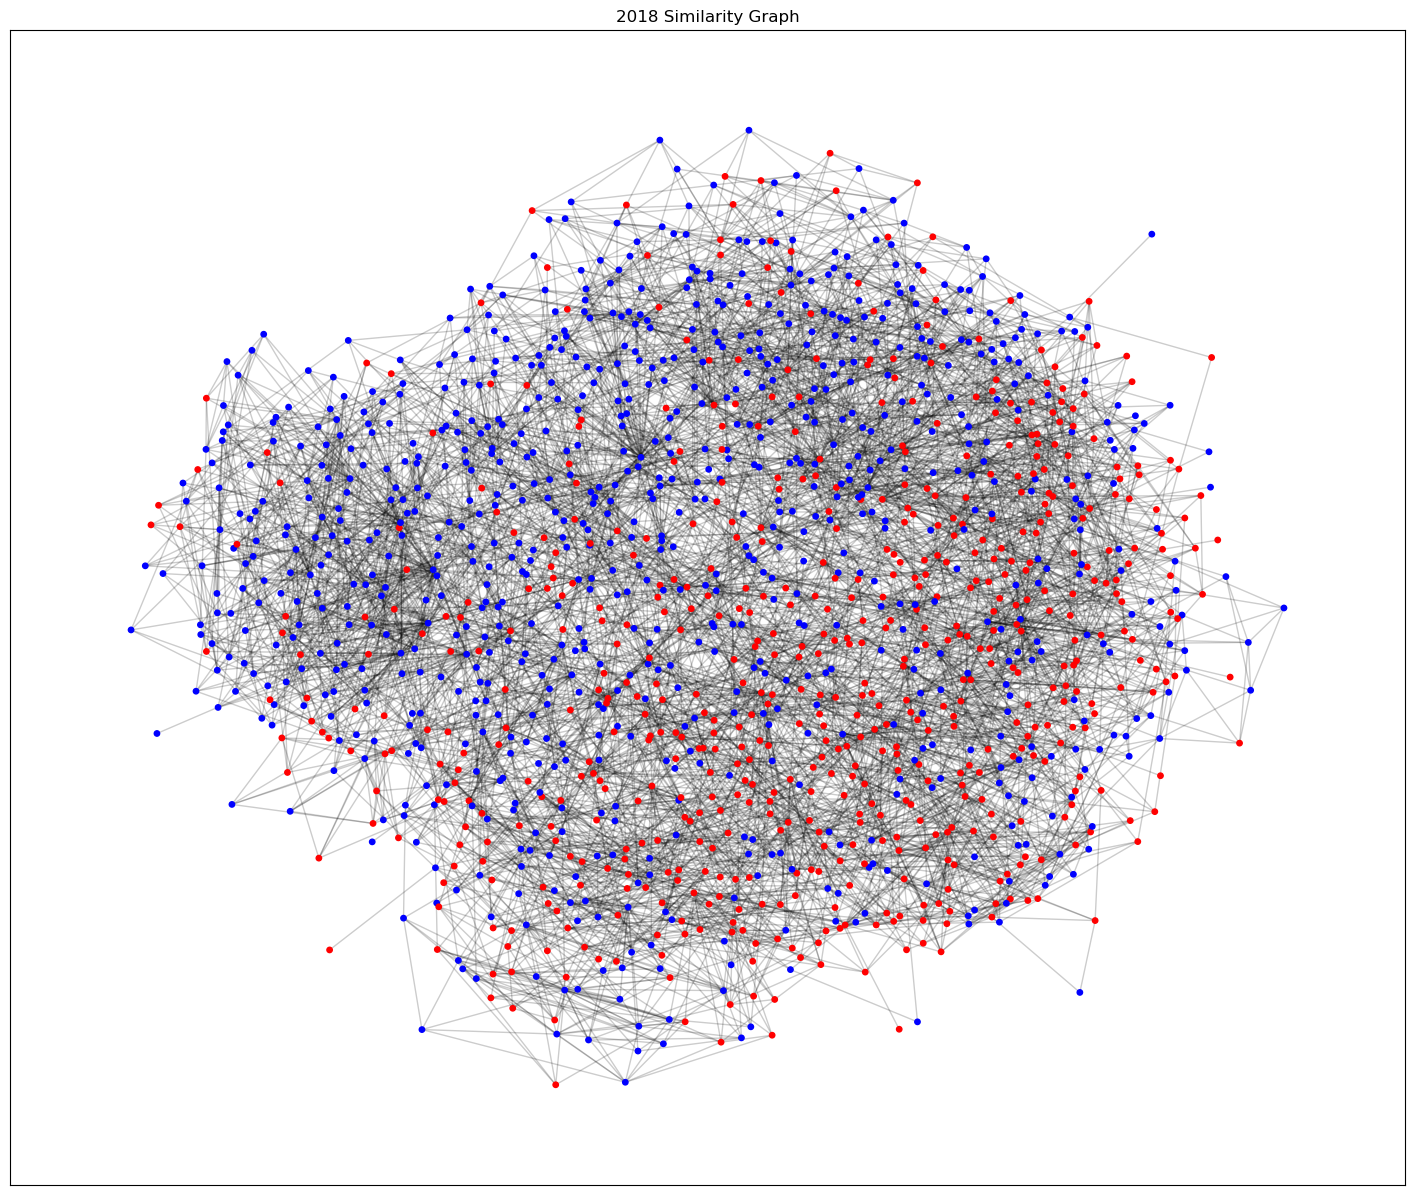

In [24]:
colors = {"Republican": "red", "Democrat": "blue"}

colors_2018 = []
for entry in G_2018.nodes():
    cand_party = G_2018.nodes[entry].get("cand_party")
    if(cand_party != None):
        colors_2018.append(colors[cand_party])
    else:
        colors_2018.append("gray")

plt.close("all")
plt.figure(figsize=(18,15))
# position = nx.spring_layout(G_2018, seed=1, k=2, iterations=100, scale=5, weight="sim")
position = nx.kamada_kawai_layout(G_2018, weight="weight")
nx.draw_networkx_nodes(G_2018, pos=position, node_color=colors_2018, node_size=15)
nx.draw_networkx_edges(G_2018, pos=position, alpha=.2)
plt.title("2018 Similarity Graph")
plt.show()